# 1. Import Library

In [1]:
import os
import pandas as pd
import difflib
from collections import defaultdict
import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
path_electricity_generation = r"CLEAN_DATA\CLEAN_DATA_BEFORE_ENGINEERING\Electricity_Generation_Processed.csv"
path_population = r"CLEAN_DATA\CLEAN_DATA_BEFORE_ENGINEERING\population_monthly.csv"
path_sunshine = r"CLEAN_DATA\CLEAN_DATA_BEFORE_ENGINEERING\sunshine_monthly.csv"
path_humidity = r"CLEAN_DATA\CLEAN_DATA_BEFORE_ENGINEERING\vietnam-humidity-handled-data.csv"
path_rainfall = r"CLEAN_DATA\CLEAN_DATA_BEFORE_ENGINEERING\vietnam-rainfall-handled-data.csv"
path_temperature = r"CLEAN_DATA\CLEAN_DATA_BEFORE_ENGINEERING\vietnam-temperature-handled-data.csv"

In [3]:
output_path_electricity_generation = r"CLEAN_DATA\CLEAN_DATA_AFTER_ENGINEERING\Electricity_Generation_Processed.csv"
output_path_population = r"CLEAN_DATA\CLEAN_DATA_AFTER_ENGINEERING\population_monthly.csv"
output_path_sunshine = r"CLEAN_DATA\CLEAN_DATA_AFTER_ENGINEERING\sunshine_monthly.csv"
output_path_humidity = r"CLEAN_DATA\CLEAN_DATA_AFTER_ENGINEERING\vietnam-humidity-handled-data.csv"
output_path_rainfall = r"CLEAN_DATA\CLEAN_DATA_AFTER_ENGINEERING\vietnam-rainfall-handled-data.csv"
output_path_temperature = r"CLEAN_DATA\CLEAN_DATA_AFTER_ENGINEERING\vietnam-temperature-handled-data.csv"

In [4]:
electricity_df = pd.read_csv(path_electricity_generation)
population_df = pd.read_csv(path_population)
sunshine_df = pd.read_csv(path_sunshine)
humidity_df = pd.read_csv(path_humidity)
rainfall_df = pd.read_csv(path_rainfall)
temperature_df = pd.read_csv(path_temperature)


In [5]:
# List các đường dẫn
paths = [
    path_electricity_generation,
    path_population,
    path_sunshine,
    path_humidity,
    path_rainfall,
    path_temperature,
]

In [6]:
YEARS = [year for year in range(2002, 2023)]

In [7]:
MONTHS = [month for month in range(1, 13)]

In [8]:
def interpolation_outliers(serie, outlier_idxs):
    """
    Interpolate the outliers in the dataframe
    """
    for outlier_idx in outlier_idxs:
        if serie.index[outlier_idx].year < 2024:
            serie.iloc[outlier_idx] = serie.iloc[outlier_idx - 12] + (
                serie.iloc[outlier_idx + 12] - serie.iloc[outlier_idx - 12]
            ) / 2
    return serie

# 2. Visualizing Single Variable 

## 2.1 Electricity Generation

In [9]:
electricity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        316 non-null    object 
 1   Generation  316 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.1+ KB


In [10]:
electricity_df.head()

,Date,Generation
0,1998-01-01,1685.1
1,1998-02-01,1571.1
2,1998-03-01,1814.4
3,1998-04-01,1797.4
4,1998-05-01,1798.1


In [11]:
# Tạo cột Date từ Year và Month
electricity_df['Date'] = pd.to_datetime(electricity_df['Date'])

# Đặt cột Date làm chỉ mục
electricity_df.set_index('Date', inplace=True)

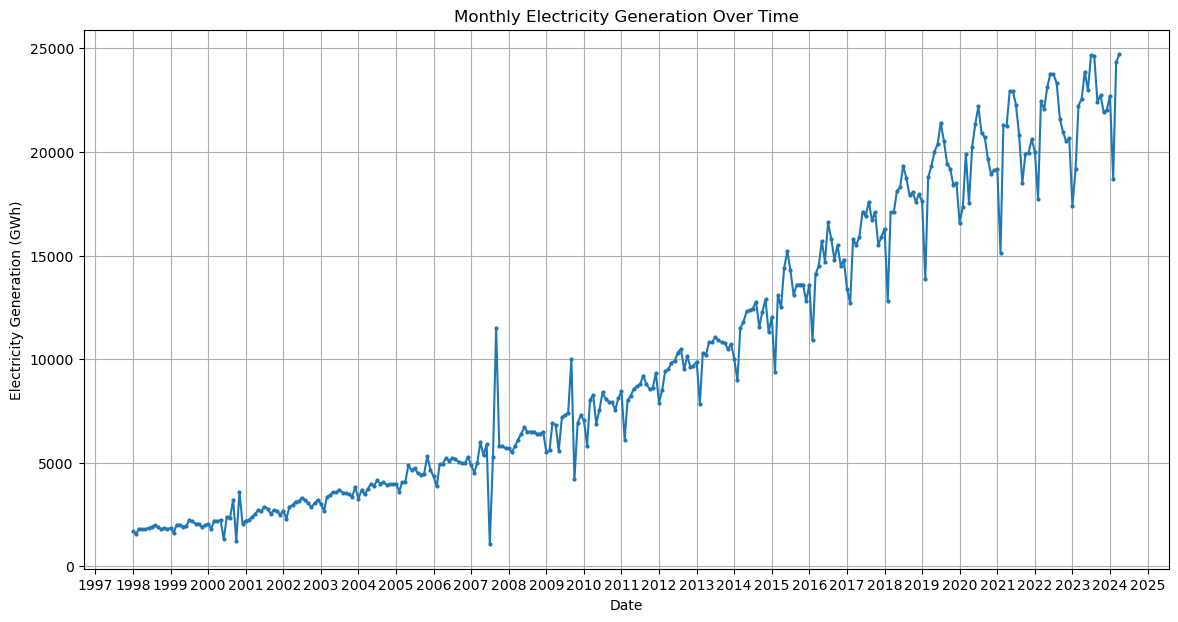

In [12]:
# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(electricity_df.index, electricity_df['Generation'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Electricity Generation (GWh)')
plt.title('Monthly Electricity Generation Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

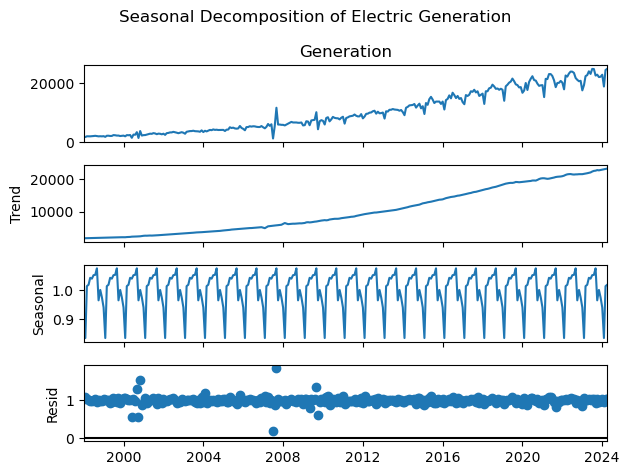

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(electricity_df['Generation'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of Electric Generation')
plt.tight_layout()
plt.show()

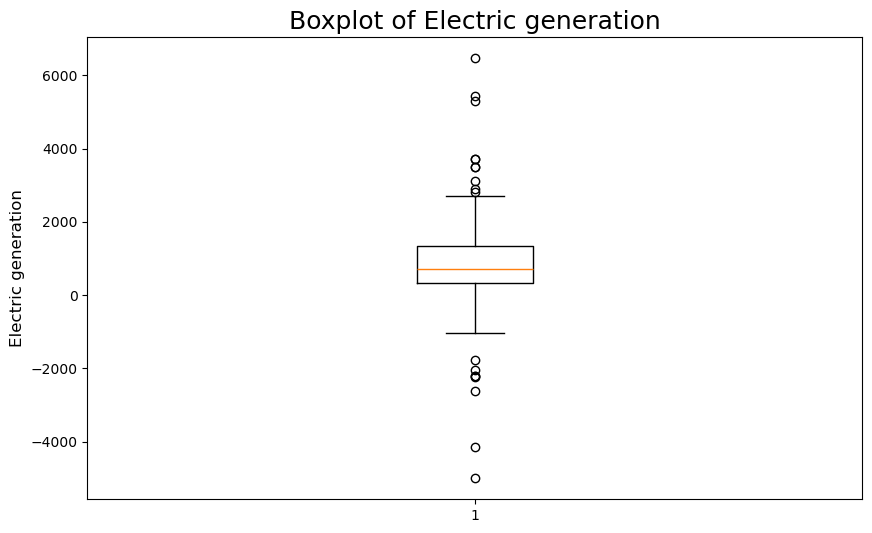

In [14]:
electric_diff = electricity_df['Generation'][12:].values - electricity_df['Generation'][:-12].values

plt.figure(figsize=(10, 6))
plt.boxplot(electric_diff)
plt.ylabel("Electric generation", fontsize=12)
plt.title("Boxplot of Electric generation", fontsize=18)
plt.show()

In [15]:
import numpy as np

def detect_outliers(series):
  """
    series: 1-D numpy array input
  """
  Q1 = np.quantile(series, 0.25)
  Q3 = np.quantile(series, 0.75)
  IQR = Q3-Q1
  lower_bound = Q1-1.5*IQR
  upper_bound = Q3+1.5*IQR
  lower_compare = series <= lower_bound
  upper_compare = series >= upper_bound
  outlier_idxs = np.where(lower_compare | upper_compare)[0]
  return outlier_idxs

electricity_outlier_idxs=detect_outliers(electric_diff)
electricity_outlier_month = electricity_df['Generation'].index[electricity_outlier_idxs+12].values
print("Outlier indices: ", electricity_outlier_idxs)
print("Outlier months: ", electricity_outlier_month)
print("Outlier values: ", electric_diff[electricity_outlier_idxs])

Outlier indices:  [102 104 114 116 128 129 140 141 197 228 253 255 265 267 272 284 288 300]
Outlier months:  ['2007-07-01T00:00:00.000000000' '2007-09-01T00:00:00.000000000'
 '2008-07-01T00:00:00.000000000' '2008-09-01T00:00:00.000000000'
 '2009-09-01T00:00:00.000000000' '2009-10-01T00:00:00.000000000'
 '2010-09-01T00:00:00.000000000' '2010-10-01T00:00:00.000000000'
 '2015-06-01T00:00:00.000000000' '2018-01-01T00:00:00.000000000'
 '2020-02-01T00:00:00.000000000' '2020-04-01T00:00:00.000000000'
 '2021-02-01T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-09-01T00:00:00.000000000' '2022-09-01T00:00:00.000000000'
 '2023-01-01T00:00:00.000000000' '2024-01-01T00:00:00.000000000']
Outlier values:  [-4149.3         6464.2         5433.8        -5000.
  3490.         -2200.         -2046.          3719.87
  2822.944       2900.          3484.865      -1780.258
 -2235.134       3702.0360612  -2214.77351311  3102.41452446
 -2617.397352    5310.05945921]


In [16]:
electricity_df['Generation'] = interpolation_outliers(electricity_df['Generation'], electricity_outlier_idxs+12)

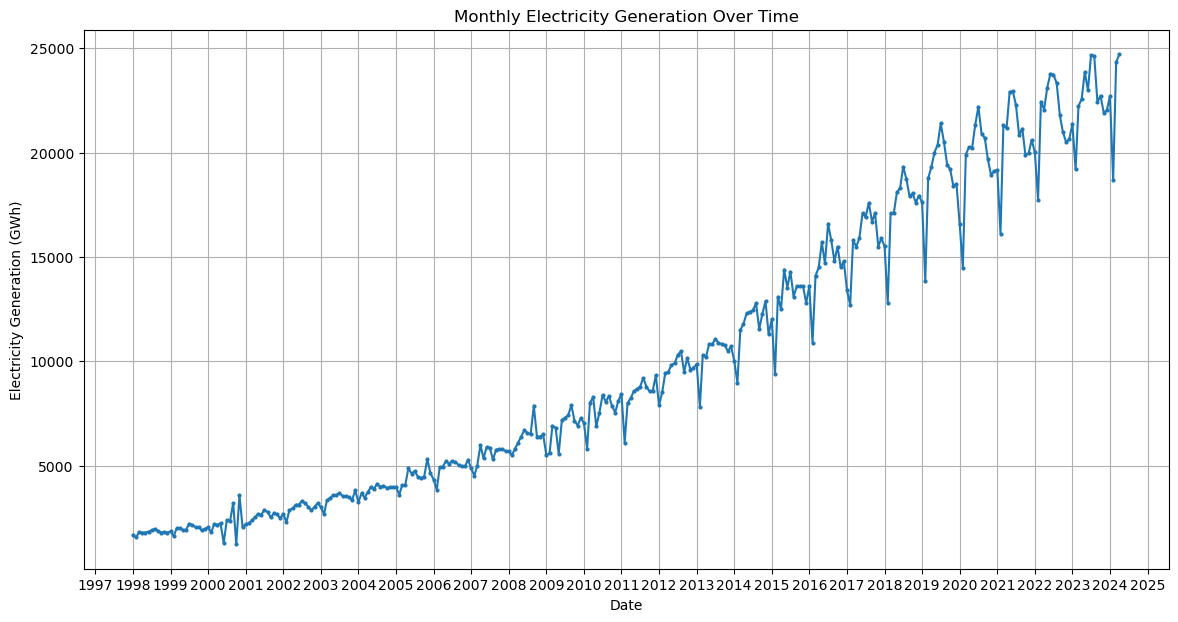

In [17]:
# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(electricity_df.index, electricity_df['Generation'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Electricity Generation (GWh)')
plt.title('Monthly Electricity Generation Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

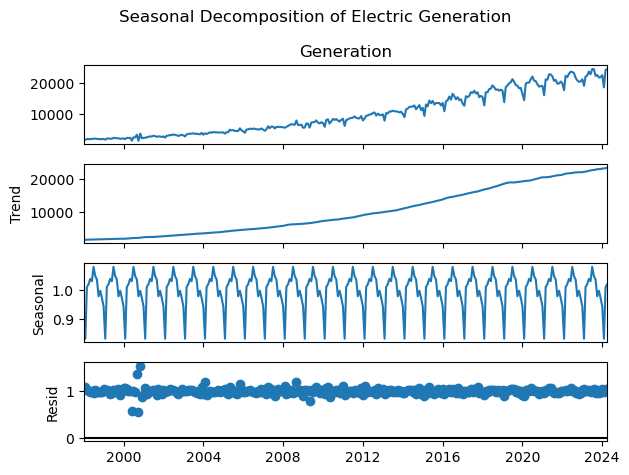

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(electricity_df['Generation'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of Electric Generation')
plt.tight_layout()
plt.show()

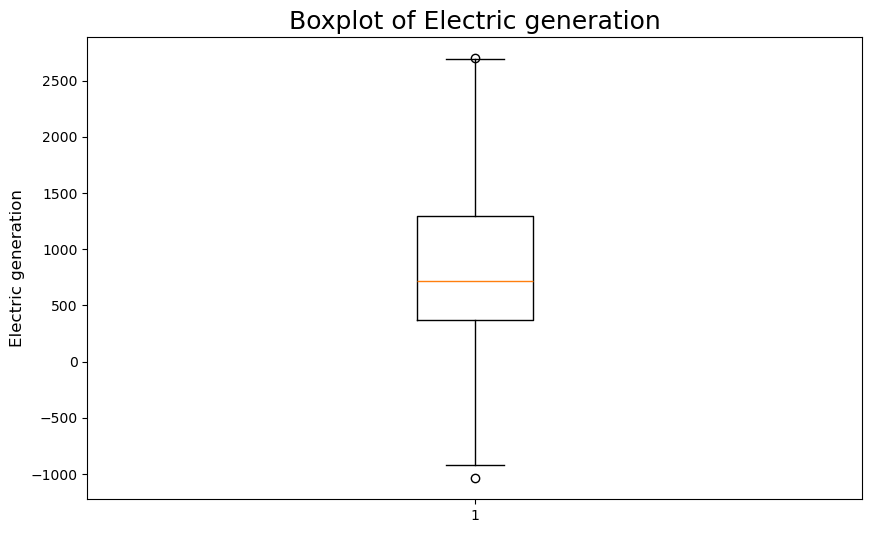

In [19]:
electric_diff = electricity_df['Generation'][12:].values - electricity_df['Generation'][:-12].values

plt.figure(figsize=(10, 6))
plt.boxplot(electric_diff)
plt.ylabel("Electric generation", fontsize=12)
plt.title("Boxplot of Electric generation", fontsize=18)
plt.show()

In [20]:
electricity_df.reset_index()

,Date,Generation
0,1998-01-01,1685.100000
1,1998-02-01,1571.100000
2,1998-03-01,1814.400000
3,1998-04-01,1797.400000
4,1998-05-01,1798.100000
...,...,...
311,2023-12-01,22022.561156
312,2024-01-01,22710.059459
313,2024-02-01,18710.839400
314,2024-03-01,24323.225379


In [21]:
electricity_df.reset_index().to_csv(output_path_electricity_generation, index=False)

## 2.2 Temperature Data

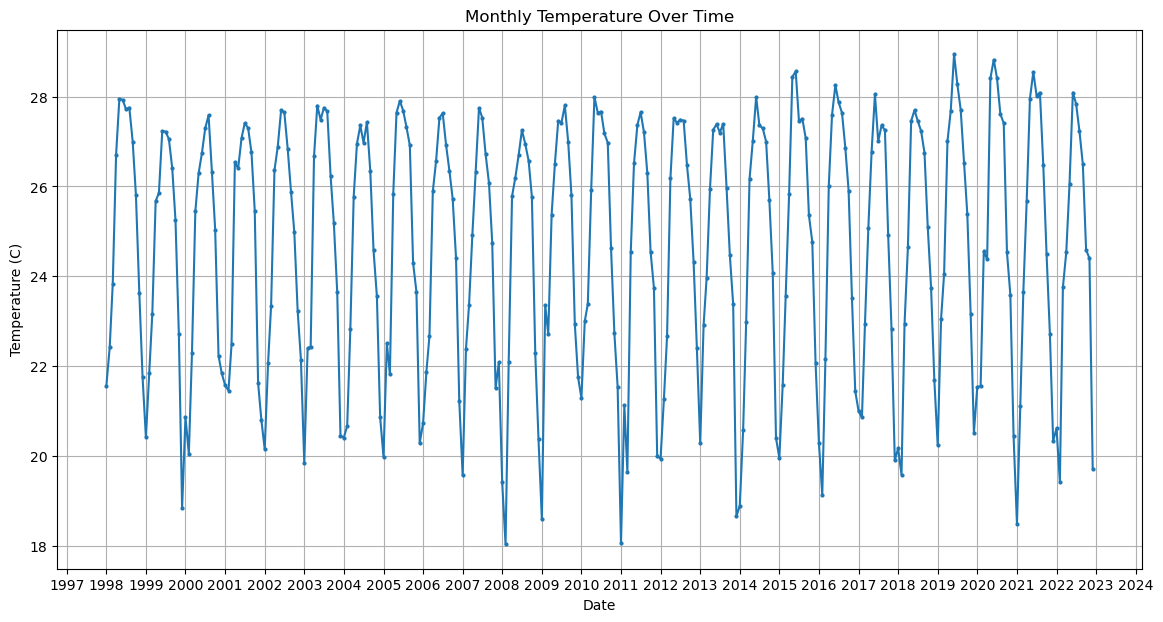

In [22]:
# Tạo cột Date từ Year và Month
temperature_df['Date'] = pd.to_datetime(temperature_df['Date'])

# Đặt cột Date làm chỉ mục
temperature_df.set_index('Date', inplace=True)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(temperature_df.index, temperature_df['Temperature'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.title('Monthly Temperature Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

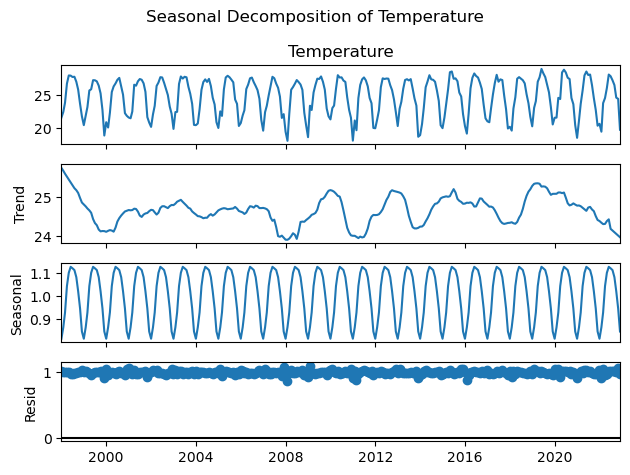

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(temperature_df['Temperature'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of Temperature')
plt.tight_layout()
plt.show()

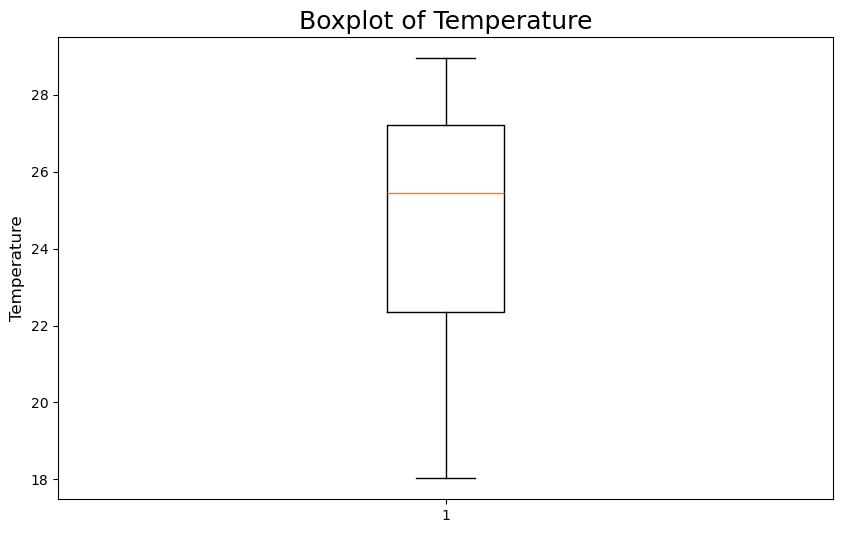

In [24]:
plt.figure(figsize=(10, 6))
plt.boxplot(temperature_df['Temperature'])
plt.ylabel("Temperature", fontsize=12)
plt.title("Boxplot of Temperature", fontsize=18)
plt.show()

In [25]:
import numpy as np

def detect_outliers(series):
  """
    series: 1-D numpy array input
  """
  Q1 = np.quantile(series, 0.25)
  Q3 = np.quantile(series, 0.75)
  IQR = Q3-Q1
  lower_bound = Q1-1.5*IQR
  upper_bound = Q3+1.5*IQR
  lower_compare = series <= lower_bound
  upper_compare = series >= upper_bound
  outlier_idxs = np.where(lower_compare | upper_compare)[0]
  return outlier_idxs

outlier_idxs=detect_outliers(temperature_df['Temperature'])
print("Outlier indices: ", outlier_idxs)
print("Outlier months: ", temperature_df['Temperature'].index[outlier_idxs].values)
print("Outlier values: ", temperature_df['Temperature'][outlier_idxs])

Outlier indices:  []
Outlier months:  []
Outlier values:  Series([], Name: Temperature, dtype: float64)


C:\Users\leatu\AppData\Local\Temp\ipykernel_4860\2158262408.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Outlier values: ", temperature_df['Temperature'][outlier_idxs])


In [33]:
temperature_df.reset_index()

,Date,Temperature
0,1998-01-01,21.552700
1,1998-02-01,22.417100
2,1998-03-01,23.828200
3,1998-04-01,26.708900
4,1998-05-01,27.953800
...,...,...
295,2022-08-01,27.226667
296,2022-09-01,26.493333
297,2022-10-01,24.586667
298,2022-11-01,24.400000


In [34]:
temperature_df.reset_index().to_csv(output_path_temperature, index=False)

## 2.3 Humidity Data

In [ ]:
# Tạo cột Date từ Year và Month
humidity_df['Date'] = pd.to_datetime(humidity_df['Date'])

# Đặt cột Date làm chỉ mục
humidity_df.set_index('Date', inplace=True)

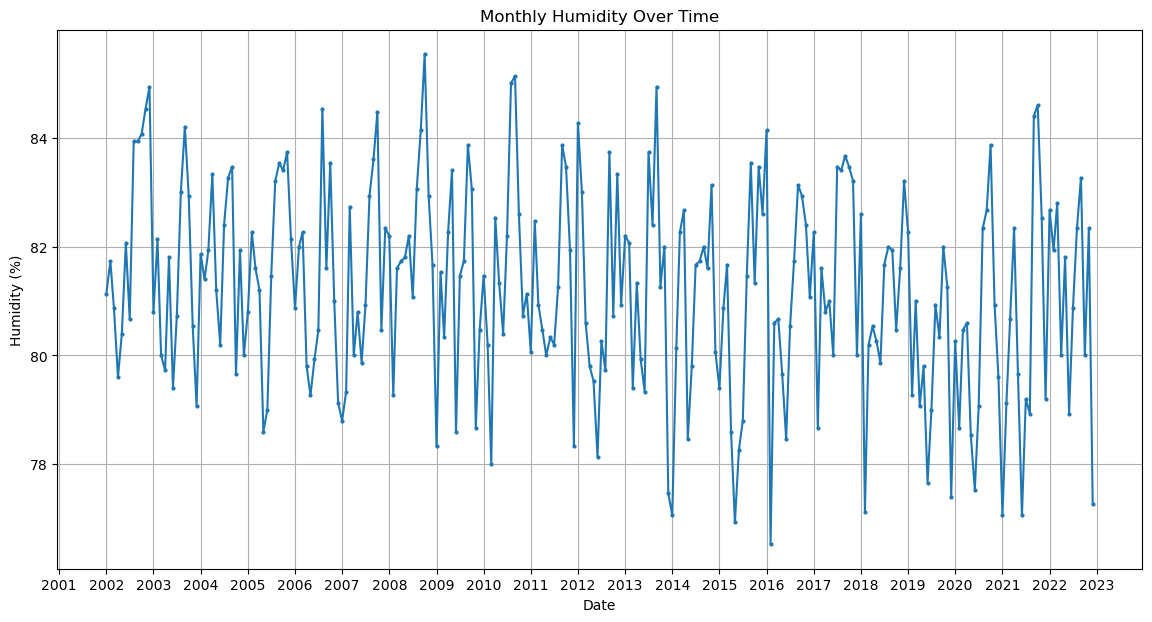

In [26]:
# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(humidity_df.index, humidity_df['Humidity'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Monthly Humidity Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

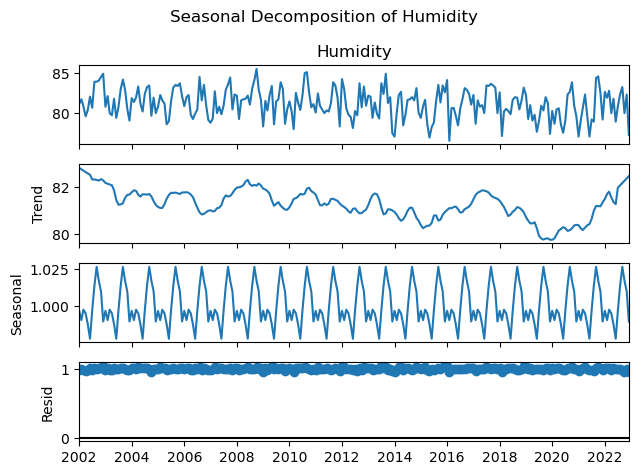

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(humidity_df['Humidity'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of Humidity')
plt.tight_layout()
plt.show()

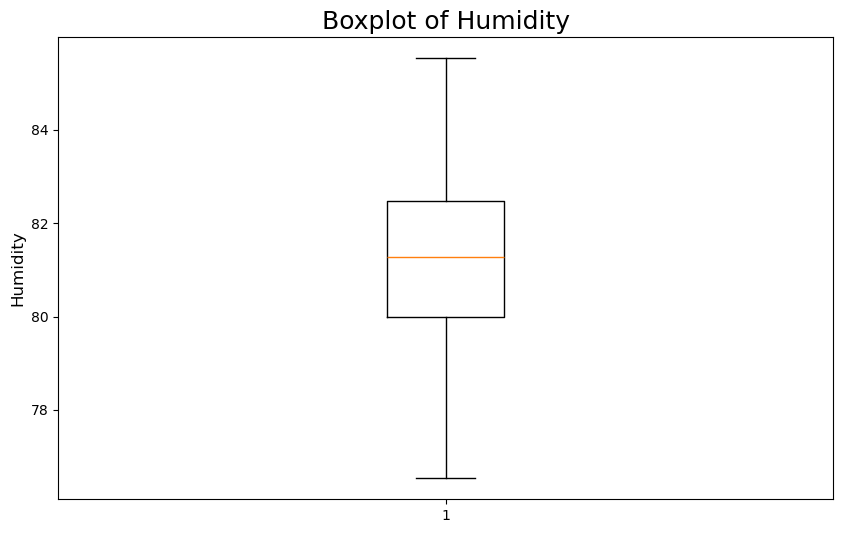

In [28]:
plt.figure(figsize=(10, 6))
plt.boxplot(humidity_df['Humidity'])
plt.ylabel("Humidity", fontsize=12)
plt.title("Boxplot of Humidity", fontsize=18)
plt.show()

In [29]:
import numpy as np

def detect_outliers(series):
  """
    series: 1-D numpy array input
  """
  Q1 = np.quantile(series, 0.25)
  Q3 = np.quantile(series, 0.75)
  IQR = Q3-Q1
  lower_bound = Q1-1.5*IQR
  upper_bound = Q3+1.5*IQR
  lower_compare = series <= lower_bound
  upper_compare = series >= upper_bound
  outlier_idxs = np.where(lower_compare | upper_compare)[0]
  return outlier_idxs

outlier_idxs=detect_outliers(humidity_df['Humidity'])
print("Outlier indices: ", outlier_idxs)
print("Outlier months: ", humidity_df['Humidity'].index[outlier_idxs].values)
print("Outlier values: ", humidity_df['Humidity'][outlier_idxs])

Outlier indices:  []
Outlier months:  []
Outlier values:  Series([], Name: Humidity, dtype: float64)


C:\Users\leatu\AppData\Local\Temp\ipykernel_4860\4229665037.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Outlier values: ", humidity_df['Humidity'][outlier_idxs])


In [35]:
humidity_df.reset_index()

,Date,Humidity
0,2002-01-01,81.133333
1,2002-02-01,81.733333
2,2002-03-01,80.866667
3,2002-04-01,79.600000
4,2002-05-01,80.400000
...,...,...
247,2022-08-01,82.333333
248,2022-09-01,83.266667
249,2022-10-01,80.000000
250,2022-11-01,82.333333


In [76]:
humidity_df.reset_index().to_csv(output_path_humidity, index=False)

## 2.4 Rainfall Data

In [ ]:
# Tạo cột Date từ Year và Month
rainfall_df['Date'] = pd.to_datetime(rainfall_df['Date'])

# Đặt cột Date làm chỉ mục
rainfall_df.set_index('Date', inplace=True)

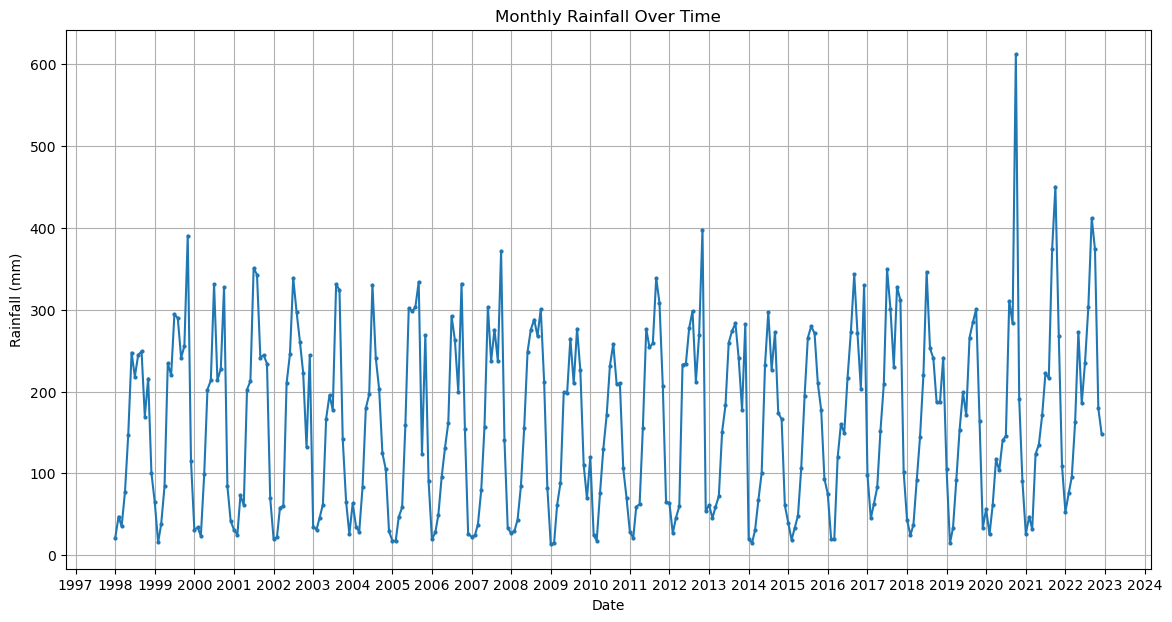

In [38]:

# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(rainfall_df.index, rainfall_df['Rainfall'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Monthly Rainfall Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

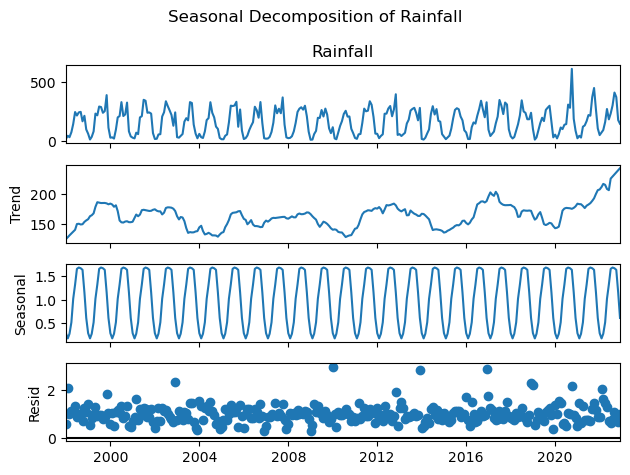

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(rainfall_df['Rainfall'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of Rainfall')
plt.tight_layout()
plt.show()

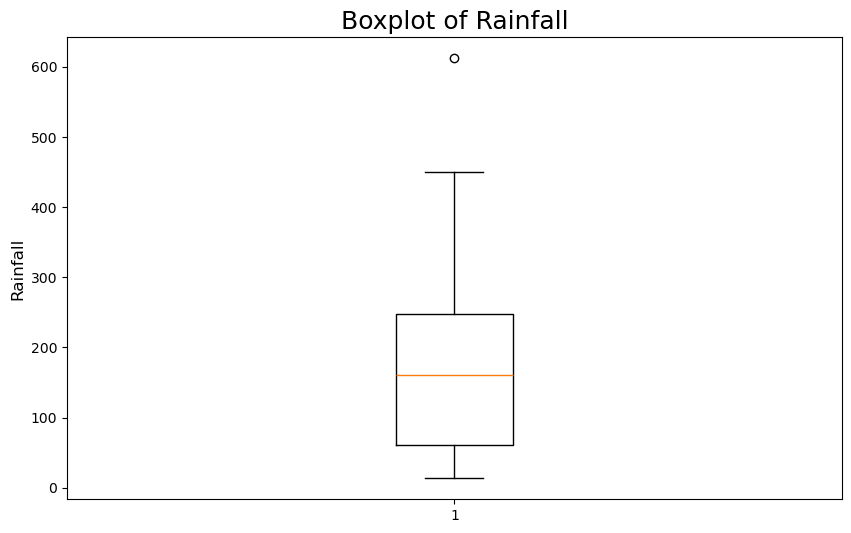

In [40]:
plt.figure(figsize=(10, 6))
plt.boxplot(rainfall_df['Rainfall'])
plt.ylabel("Rainfall", fontsize=12)
plt.title("Boxplot of Rainfall", fontsize=18)
plt.show()

In [41]:
import numpy as np

def detect_outliers(series):
  """
    series: 1-D numpy array input
  """
  Q1 = np.quantile(series, 0.25)
  Q3 = np.quantile(series, 0.75)
  IQR = Q3-Q1
  lower_bound = Q1-1.5*IQR
  upper_bound = Q3+1.5*IQR
  lower_compare = series <= lower_bound
  upper_compare = series >= upper_bound
  outlier_idxs = np.where(lower_compare | upper_compare)[0]
  return outlier_idxs

outlier_idxs=detect_outliers(rainfall_df['Rainfall'])
print("Outlier indices: ", outlier_idxs)
print("Outlier months: ", rainfall_df['Rainfall'].index[outlier_idxs].values)
print("Outlier values: ", rainfall_df['Rainfall'][outlier_idxs])

Outlier indices:  [273]
Outlier months:  ['2020-10-01T00:00:00.000000000']
Outlier values:  Date
2020-10-01    612.273333
Name: Rainfall, dtype: float64


C:\Users\leatu\AppData\Local\Temp\ipykernel_4860\3450725014.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Outlier values: ", rainfall_df['Rainfall'][outlier_idxs])


In [42]:
rainfall_df['Rainfall'] = interpolation_outliers(rainfall_df['Rainfall'], outlier_idxs)

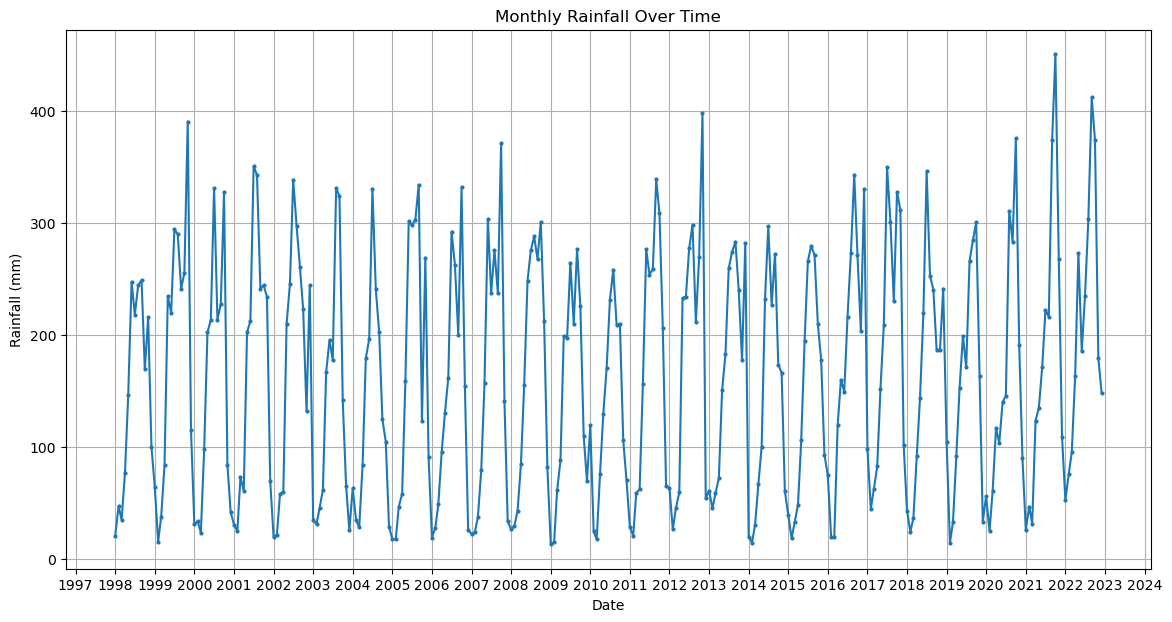

In [43]:
# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(rainfall_df.index, rainfall_df['Rainfall'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Monthly Rainfall Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

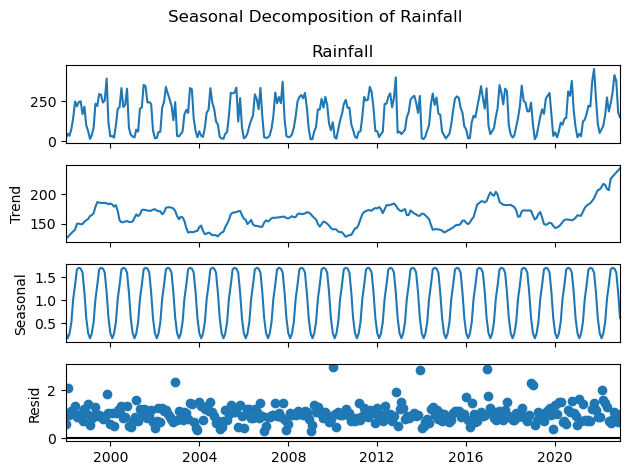

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(rainfall_df['Rainfall'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of Rainfall')
plt.tight_layout()
plt.show()

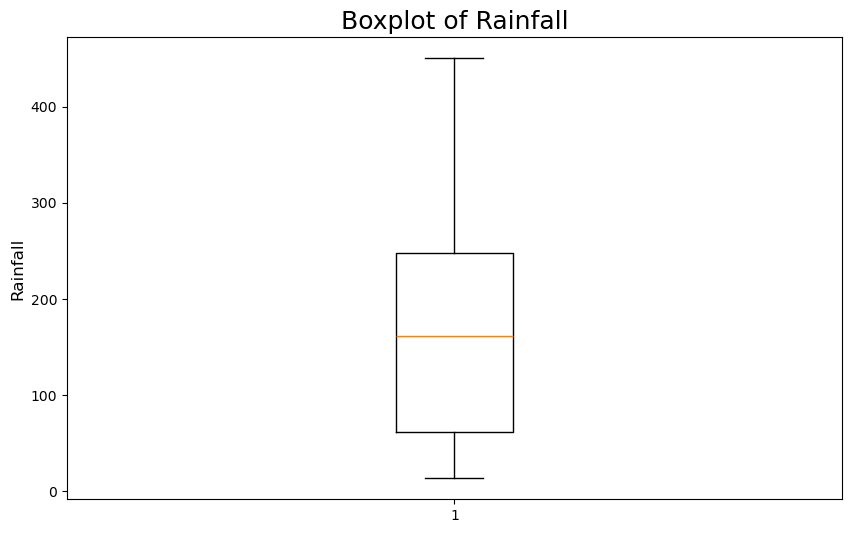

In [45]:
plt.figure(figsize=(10, 6))
plt.boxplot(rainfall_df['Rainfall'])
plt.ylabel("Rainfall", fontsize=12)
plt.title("Boxplot of Rainfall", fontsize=18)
plt.show()

In [46]:
rainfall_df.reset_index()

,Date,Rainfall
0,1998-01-01,20.883900
1,1998-02-01,47.191800
2,1998-03-01,35.086800
3,1998-04-01,77.234000
4,1998-05-01,146.659000
...,...,...
295,2022-08-01,303.686667
296,2022-09-01,412.233333
297,2022-10-01,373.926667
298,2022-11-01,179.473333


In [75]:
rainfall_df.reset_index().to_csv(output_path_rainfall, index=False)

## 2.5 Sunshine Data

In [48]:
# Tạo cột Date từ Year và Month
sunshine_df['Date'] = pd.to_datetime(sunshine_df['Date'])

# Đặt cột Date làm chỉ mục
sunshine_df.set_index('Date', inplace=True)

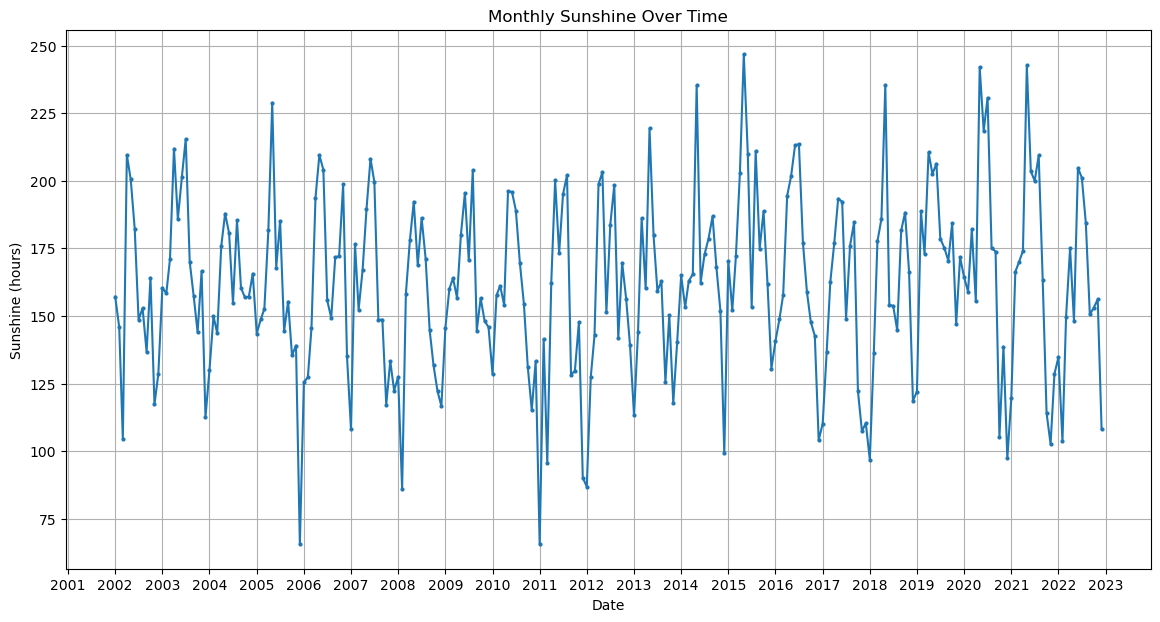

In [49]:
# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(sunshine_df.index, sunshine_df['Average Sunshine'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Sunshine (hours)')
plt.title('Monthly Sunshine Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

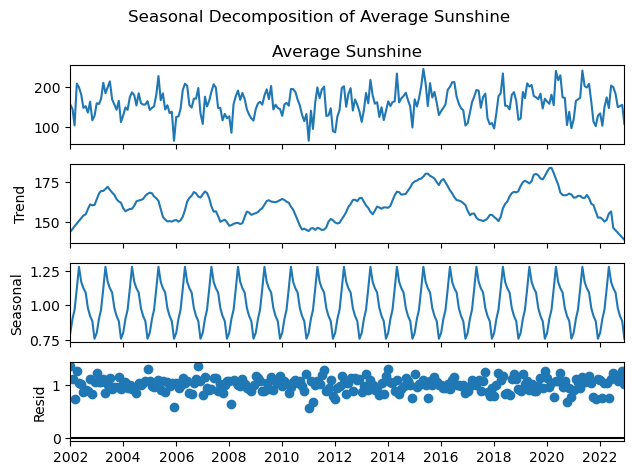

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(sunshine_df['Average Sunshine'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of Average Sunshine')
plt.tight_layout()
plt.show()

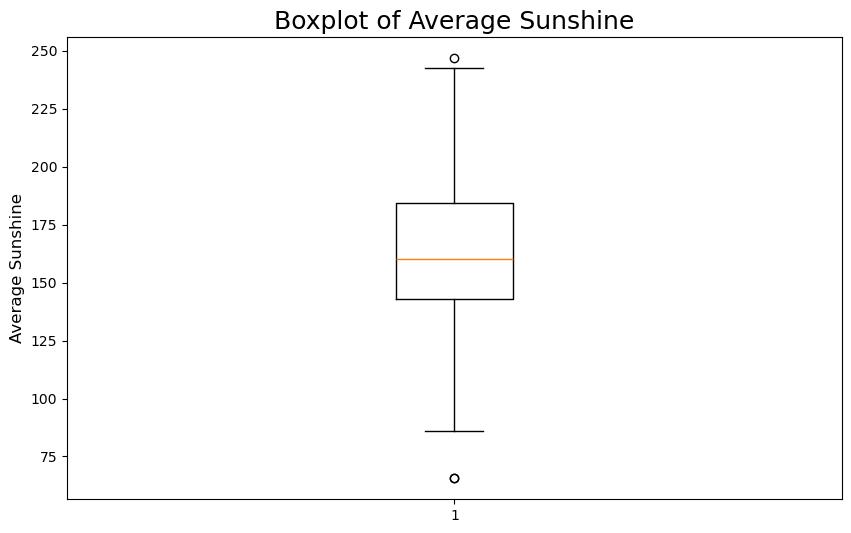

In [52]:
plt.figure(figsize=(10, 6))
plt.boxplot(sunshine_df['Average Sunshine'])
plt.ylabel("Average Sunshine", fontsize=12)
plt.title("Boxplot of Average Sunshine", fontsize=18)
plt.show()

In [53]:
import numpy as np

def detect_outliers(series):
  """
    series: 1-D numpy array input
  """
  Q1 = np.quantile(series, 0.25)
  Q3 = np.quantile(series, 0.75)
  IQR = Q3-Q1
  lower_bound = Q1-1.5*IQR
  upper_bound = Q3+1.5*IQR
  lower_compare = series <= lower_bound
  upper_compare = series >= upper_bound
  outlier_idxs = np.where(lower_compare | upper_compare)[0]
  return outlier_idxs

outlier_idxs=detect_outliers(sunshine_df['Average Sunshine'])
print("Outlier indices: ", outlier_idxs)
print("Outlier months: ", sunshine_df['Average Sunshine'].index[outlier_idxs].values)
print("Outlier values: ", sunshine_df['Average Sunshine'][outlier_idxs])

Outlier indices:  [ 47 108 160]
Outlier months:  ['2005-12-01T00:00:00.000000000' '2011-01-01T00:00:00.000000000'
 '2015-05-01T00:00:00.000000000']
Outlier values:  Date
2005-12-01     65.600000
2011-01-01     65.806667
2015-05-01    246.786667
Name: Average Sunshine, dtype: float64


C:\Users\leatu\AppData\Local\Temp\ipykernel_4860\1606138387.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Outlier values: ", sunshine_df['Average Sunshine'][outlier_idxs])


In [54]:
interpolation_outliers(sunshine_df['Average Sunshine'], outlier_idxs)

Date
2002-01-01    157.133333
2002-02-01    145.800000
2002-03-01    104.400000
2002-04-01    209.600000
2002-05-01    200.533333
                 ...    
2022-08-01    184.360000
2022-09-01    150.546667
2022-10-01    153.026667
2022-11-01    156.140000
2022-12-01    108.173333
Name: Average Sunshine, Length: 252, dtype: float64

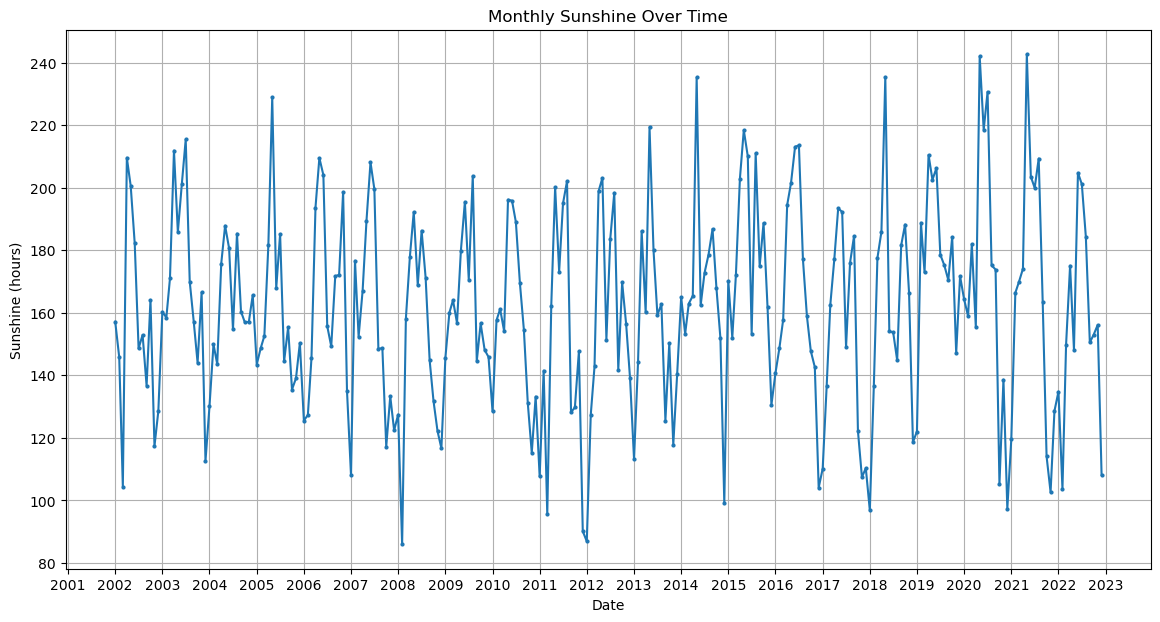

In [56]:
# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(sunshine_df.index, sunshine_df['Average Sunshine'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Sunshine (hours)')
plt.title('Monthly Sunshine Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

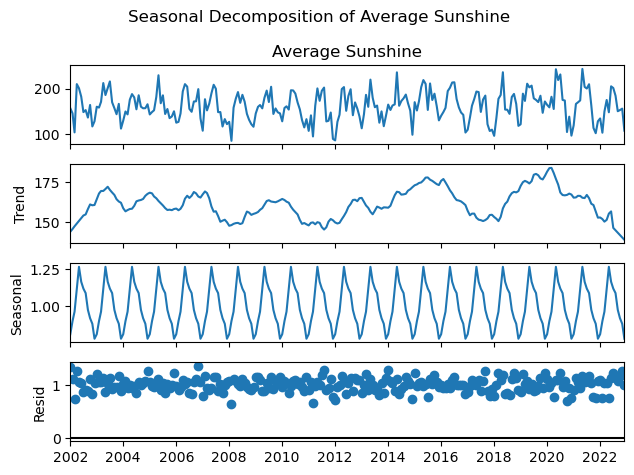

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(sunshine_df['Average Sunshine'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of Average Sunshine')
plt.tight_layout()
plt.show()

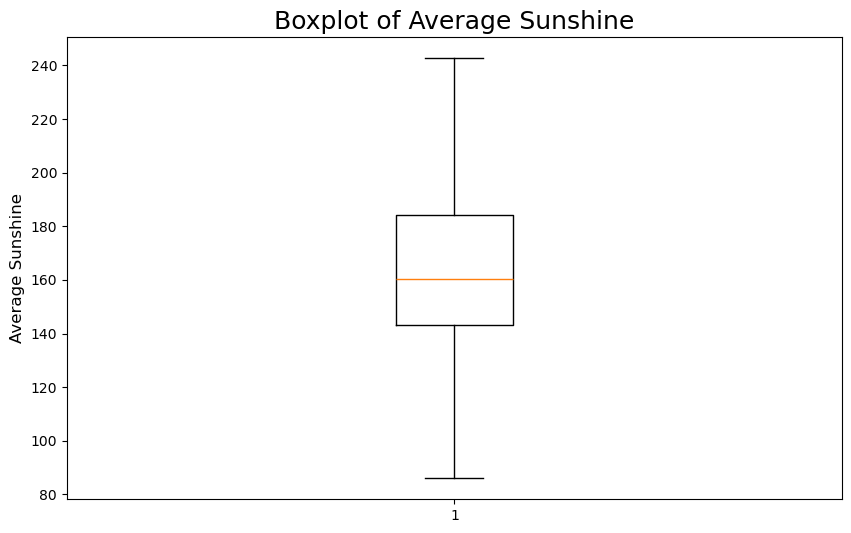

In [58]:
plt.figure(figsize=(10, 6))
plt.boxplot(sunshine_df['Average Sunshine'])
plt.ylabel("Average Sunshine", fontsize=12)
plt.title("Boxplot of Average Sunshine", fontsize=18)
plt.show()

In [59]:
sunshine_df.reset_index()

,Date,Average Sunshine
0,2002-01-01,157.133333
1,2002-02-01,145.800000
2,2002-03-01,104.400000
3,2002-04-01,209.600000
4,2002-05-01,200.533333
...,...,...
247,2022-08-01,184.360000
248,2022-09-01,150.546667
249,2022-10-01,153.026667
250,2022-11-01,156.140000


In [74]:
sunshine_df.reset_index().to_csv(output_path_sunshine, index=False)

## 2.6 Population Data

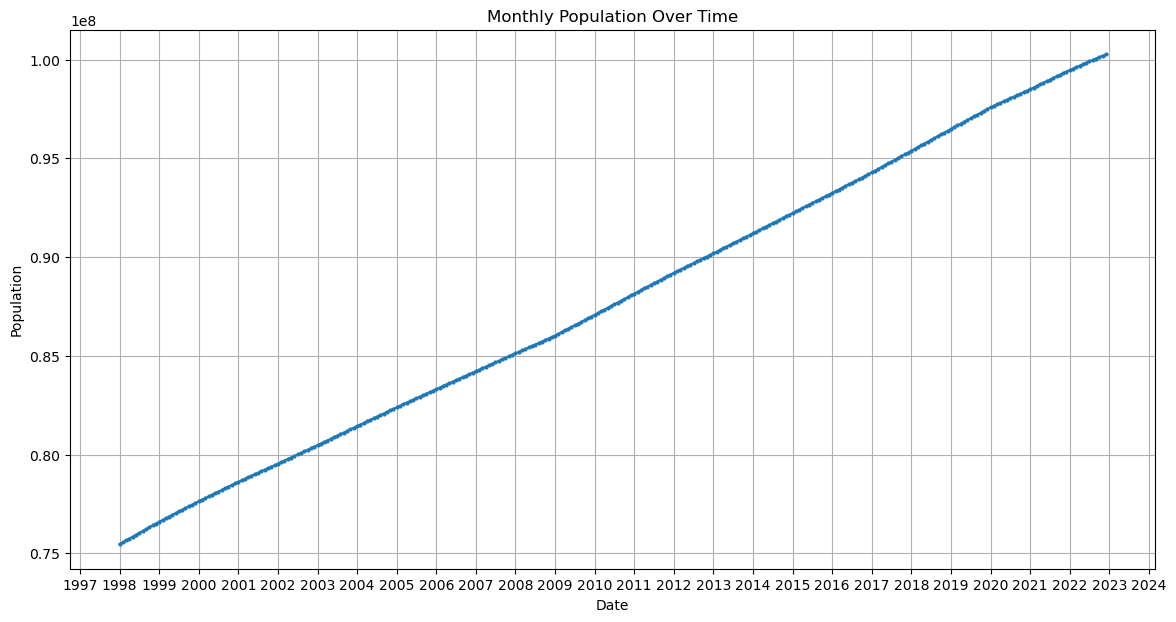

In [65]:
# Tạo cột Date từ Year và Month
population_df['Date'] = pd.to_datetime(population_df['Date'])

# Đặt cột Date làm chỉ mục
population_df.set_index('Date', inplace=True)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plt.plot(population_df.index, population_df['Population'], marker='o', markersize=2)

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('Monthly Population Over Time')

# Định dạng nhãn trục x để hiển thị mỗi năm một lần
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hiển thị đồ thị
plt.grid(True)
plt.show()

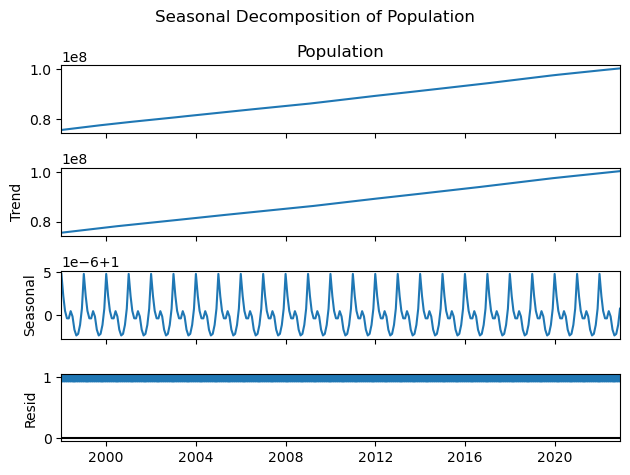

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(population_df['Population'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of Population')
plt.tight_layout()
plt.show()

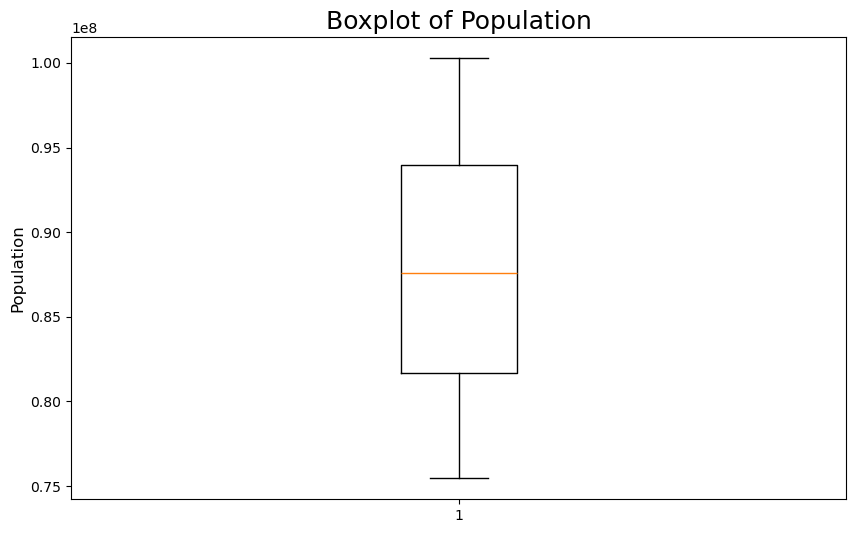

In [67]:
plt.figure(figsize=(10, 6))
plt.boxplot(population_df['Population'])
plt.ylabel("Population", fontsize=12)
plt.title("Boxplot of Population", fontsize=18)
plt.show()

In [68]:
import numpy as np

def detect_outliers(series):
  """
    series: 1-D numpy array input
  """
  Q1 = np.quantile(series, 0.25)
  Q3 = np.quantile(series, 0.75)
  IQR = Q3-Q1
  lower_bound = Q1-1.5*IQR
  upper_bound = Q3+1.5*IQR
  lower_compare = series <= lower_bound
  upper_compare = series >= upper_bound
  outlier_idxs = np.where(lower_compare | upper_compare)[0]
  return outlier_idxs

outlier_idxs=detect_outliers(population_df['Population'])
print("Outlier indices: ", outlier_idxs)
print("Outlier months: ", population_df['Population'].index[outlier_idxs].values)
print("Outlier values: ", population_df['Population'][outlier_idxs])

Outlier indices:  []
Outlier months:  []
Outlier values:  Series([], Name: Population, dtype: float64)


C:\Users\leatu\AppData\Local\Temp\ipykernel_4860\432857690.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Outlier values: ", population_df['Population'][outlier_idxs])


In [70]:
population_diff = population_df['Population'][1:].values - population_df['Population'][:-1].values

In [71]:
import numpy as np

def detect_outliers(series):
  """
    series: 1-D numpy array input
  """
  Q1 = np.quantile(series, 0.25)
  Q3 = np.quantile(series, 0.75)
  IQR = Q3-Q1
  lower_bound = Q1-1.5*IQR
  upper_bound = Q3+1.5*IQR
  lower_compare = series <= lower_bound
  upper_compare = series >= upper_bound
  outlier_idxs = np.where(lower_compare | upper_compare)[0]
  return outlier_idxs

outlier_idxs=detect_outliers(population_diff)
print("Outlier indices: ", outlier_idxs)
print("Outlier months: ", population_df['Population'].index[outlier_idxs].values)
print("Outlier values: ", population_diff[outlier_idxs])

Outlier indices:  []
Outlier months:  []
Outlier values:  []


In [72]:
population_df.reset_index()

,Date,Population
0,1998-01-01,7.545630e+07
1,1998-02-01,7.555133e+07
2,1998-03-01,7.564637e+07
3,1998-04-01,7.574140e+07
4,1998-05-01,7.583643e+07
...,...,...
295,2022-08-01,9.998415e+07
296,2022-09-01,1.000570e+08
297,2022-10-01,1.001298e+08
298,2022-11-01,1.002026e+08


In [73]:
population_df.reset_index().to_csv(output_path_population, index=False)